# Walmart Retail Sales Forecasting System

## 1. Objective and Dataset
The objective of this project is to develop a comprehensive retail sales forecasting system for Walmart using historical sales data.

## 2. Import Libraries

In [1]:
# Import functions from src directory
from retailer_sales_forecasting_system.data.extract import load_sales

# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set styles for better visualization
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100


In [2]:
# Load the sales data

df = load_sales()
df.head()

,id,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,created_at
0,1,1,2010-02-05,1643690.90,False,42.31,2.572,211.096358,8.106,2026-01-13 00:47:51.225908
1,2,1,2010-02-12,1641957.44,True,38.51,2.548,211.242170,8.106,2026-01-13 00:47:51.225908
2,3,1,2010-02-19,1611968.17,False,39.93,2.514,211.289143,8.106,2026-01-13 00:47:51.225908
3,4,1,2010-02-26,1409727.59,False,46.63,2.561,211.319643,8.106,2026-01-13 00:47:51.225908
4,5,1,2010-03-05,1554806.68,False,46.50,2.625,211.350143,8.106,2026-01-13 00:47:51.225908


## 3. Exploratory Data Analysis (EDA)

In [3]:
print("Walmart Retail Sales Data Analysis")
print("==================================")
print("\n📊 Data Overview")
print("==================================")
df.info()
print("\nFeatures: ", df.columns.tolist())

Walmart Retail Sales Data Analysis

📊 Data Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            6435 non-null   int64         
 1   store         6435 non-null   int64         
 2   date          6435 non-null   datetime64[ns]
 3   weekly_sales  6435 non-null   float64       
 4   holiday_flag  6435 non-null   bool          
 5   temperature   6435 non-null   float64       
 6   fuel_price    6435 non-null   float64       
 7   cpi           6435 non-null   float64       
 8   unemployment  6435 non-null   float64       
 9   created_at    6435 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(5), int64(2)
memory usage: 458.9 KB

Features:  ['id', 'store', 'date', 'weekly_sales', 'holiday_flag', 'temperature', 'fuel_price', 'cpi', 'unemployment', 'created_at']


In [4]:
print("📉 Data Dimensions")
print("=======================================")
print(f"✔️ Number of Records: {df.shape[0]}")
print(f"✔️ Number of Stores: {df['store'].nunique()}")
print(f"✔️ Data Range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"✔️ Total Number of Weeks in Data: {df['date'].nunique()}")
print(f"✔️ Records per Store (Average): {df.shape[0] // df['store'].nunique():.1f}")

📉 Data Dimensions
✔️ Number of Records: 6435
✔️ Number of Stores: 45
✔️ Data Range: 2010-02-05 to 2012-10-26
✔️ Total Number of Weeks in Data: 143
✔️ Records per Store (Average): 143.0


In [5]:
# Confirm if any missing values
missing_values = df.isnull().sum()
print("🔍 Missing Values Check:", missing_values[missing_values > 0] if missing_values.any() else "No missing values found.")

🔍 Missing Values Check: No missing values found.


### Observations and Insights

## 4. Correlation and Variance Explanation by External Factors

### A. Correlation Analysis - External Factors Impact on Sales


🔗 Correlation of Features with Weekly Sales:
 ∙ holiday_flag        : +0.0369
 ∙ fuel_price          : +0.0095
 ∙ temperature         : -0.0638
 ∙ cpi                 : -0.0726
 ∙ unemployment        : -0.1062


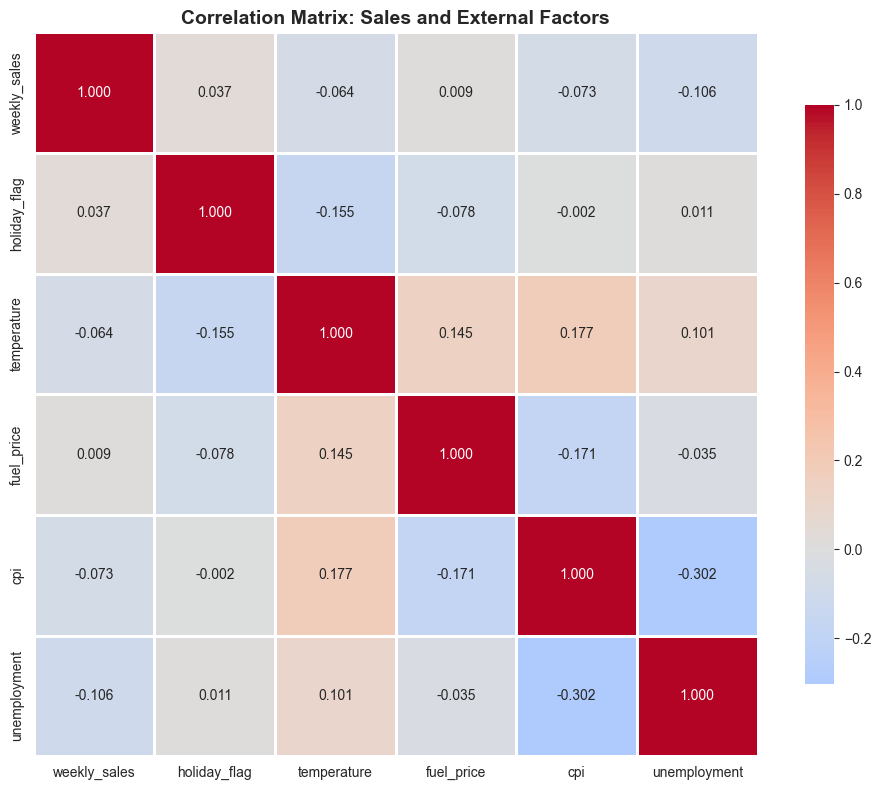

In [6]:
correlation_features = ['weekly_sales', 'holiday_flag', 'temperature', 'fuel_price', 'cpi', 'unemployment']

# Prepare data for correlation analysis
x = df[correlation_features].copy()

# Map boolean 'holiday_flag' to 0/1
if 'holiday_flag' in x.columns:
    x['holiday_flag'] = x['holiday_flag'].astype('Int64')

# Coerce other features to numeric, ignoring errors
for c in x.columns:
    if c != 'holiday_flag':
        x[c] = pd.to_numeric(x[c], errors='coerce')

correlation_df = x.corr()

print("\n🔗 Correlation of Features with Weekly Sales:")
if 'weekly_sales' in correlation_df:
    correlation_with_sales = correlation_df['weekly_sales'].drop('weekly_sales').sort_values(ascending=False)
    for feature, corr_value in correlation_with_sales.items():
        if feature != 'weekly_sales':
            print(f" ∙ {feature:20s}: {corr_value:+.4f}")
    
else:
    print("No correlation data available for 'weekly_sales'.")

# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            fmt='.3f',
            square=True,
            linewidths=1,
            cbar_kws={"shrink": .8}
)
plt.title("Correlation Matrix: Sales and External Factors", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### Observations and Insights

### B. Variance Explanation - External Factors Contribution to Sales Variance

#### Observations and Insights

In [7]:
# Temperature variance explanation (R² calculation)
X_temperature = df[['temperature']].dropna()
y_sales = df.loc[X_temperature.index, 'weekly_sales']

temperature_model = LinearRegression()
temperature_model.fit(X_temperature, y_sales)
r2_temperature = temperature_model.score(X_temperature, y_sales)

print(f"\n🌡️ Variance Explained Analysis:")
print("===================================")
print(f"\nR² Score for Temperature: {r2_temperature:.4f} ({r2_temperature * 100:.2f}% of variance explained by temperature)")

# Multiple Linear Regression for all external factors
# Create a copy to avoid modifying original dataframe
df_copy = df.copy()
# Convert boolean to 0/1 for regression
df_copy['holiday_flag'] = df_copy['holiday_flag'].astype('Int64')

# Prepare data for multiple linear regression
X_multiple_lr = df_copy[['holiday_flag', 'temperature', 'fuel_price', 'cpi', 'unemployment']].dropna()
y_multiple_lr = df_copy.loc[X_multiple_lr.index, 'weekly_sales']

multiple_lr_model = LinearRegression()
multiple_lr_model.fit(X_multiple_lr, y_multiple_lr)
r2_multiple_lr = multiple_lr_model.score(X_multiple_lr, y_multiple_lr)

print(f"R² Score for All Features: {r2_multiple_lr:.4f} ({r2_multiple_lr * 100:.2f}% of variance explained by all factors combined)")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_multiple_lr.columns,
    'Coefficient': multiple_lr_model.coef_
}).sort_values(by='Feature')

print("\n🔑 Feature Importance based on Coefficients:")
for _, row in feature_importance.iterrows():
    print(f" ∙ {row['Feature']:15s}: {row['Coefficient']:+,.2f}")


🌡️ Variance Explained Analysis:

R² Score for Temperature: 0.0041 (0.41% of variance explained by temperature)
R² Score for All Features: 0.0254 (2.54% of variance explained by all factors combined)

🔑 Feature Importance based on Coefficients:
 ∙ cpi            : -1,598.87
 ∙ fuel_price     : -10,167.88
 ∙ holiday_flag   : +74,891.66
 ∙ temperature    : -724.17
 ∙ unemployment   : -41,552.28


## 5. Store-wise Analysis and Sales Distribution

🏬 Store-wise Analysis
Top 10 Stores by Total Sales:
 1. Store  20: $301,397,792.46
 2. Store   4: $299,543,953.38
 3. Store  14: $288,999,911.34
 4. Store  13: $286,517,703.80
 5. Store   2: $275,382,440.98
 6. Store  10: $271,617,713.89
 7. Store  27: $253,855,916.88
 8. Store   6: $223,756,130.64
 9. Store   1: $222,402,808.85
10. Store  39: $207,445,542.47


/var/folders/3k/_wq4dpkn09g76hqzch61tg580000gn/T/ipykernel_58769/2675975832.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=top10_sales.values, palette='viridis')


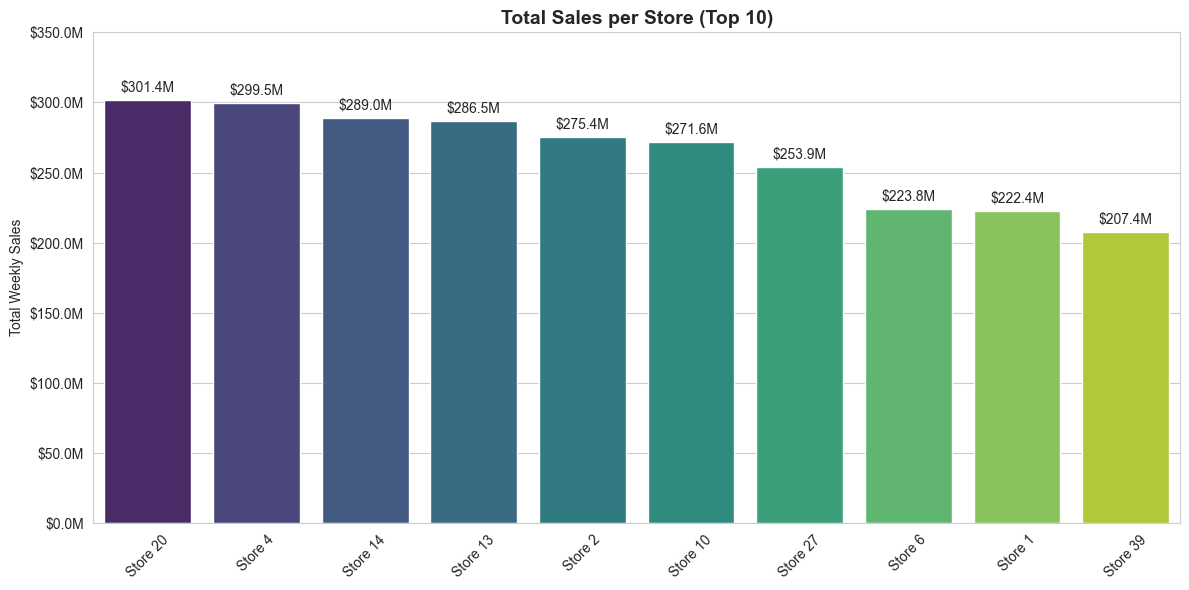

In [ ]:
import math
print("🏬 Store-wise Analysis")
print("======================")

# Total sales per store
store_sales = df.groupby('store')['weekly_sales'].sum().sort_values(ascending=False)

# Print Top 10 Stores by Total Sales
print("Top 10 Stores by Total Sales:")
for rank, (store, sales) in enumerate(store_sales.head(10).items(), start=1):
    print(f"{rank:2d}. Store {store:3d}: ${sales:,.2f}")

# Plot Total Sales per Store of Top 10 Stores
plt.figure(figsize=(12, 6))
top10_sales = store_sales.head(10)
labels = [f"Store {store}" for store in top10_sales.index]
ax = sns.barplot(x=labels, y=top10_sales.values, palette='viridis')
plt.title("Total Sales per Store (Top 10)", fontsize=14, fontweight='bold')
# plt.xlabel("Store")
plt.ylabel("Total Weekly Sales ($)")
plt.xticks(rotation=45)

# Format y-axis in $50.0M increments
max_sales = top10_sales.max()
step = 50_000_000
upper = int(math.ceil(max_sales / step) * step)
ax.set_yticks(range(0, upper + step, step))
ax.yaxis.set_major_formatter(lambda x, pos: f"${x/1e6:.1f}M")

# Add labels above bars
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(
        f"${height/1e6:.1f}M",
        (bar.get_x() + bar.get_width() / 2, height),
        ha='center',
        va='bottom',
        xytext=(0, 4),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()
